https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772

In [1]:
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import seaborn as sns
import random 
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from  tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

path = "../input/"


In [2]:
app_train = pd.read_csv(path + "application_train.csv")
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
bureau = pd.read_csv(path + "bureau.csv")
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
bureau_balance = pd.read_csv(path + "bureau_balance.csv")
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [5]:
credit_card_balance = pd.read_csv(path + "credit_card_balance.csv")
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [6]:
pcb = pd.read_csv(path + "POS_CASH_balance.csv")
pcb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [7]:
previous_application = pd.read_csv(path + "previous_application.csv")
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
installments_payments = pd.read_csv(path + "installments_payments.csv")
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


## 学習データ準備

In [9]:
from sklearn.model_selection import train_test_split 
import lightgbm as lgb

# read the test files 
app_test = pd.read_csv('../input/application_test.csv')


# Remove some rows with values not present in test set
#app_train.drop(app_train[app_train['CODE_GENDER'] == 'XNA'].index, inplace = True)
#app_train.drop(app_train[app_train['NAME_INCOME_TYPE'] == 'Maternity leave'].index, inplace = True)
#app_train.drop(app_train[app_train['NAME_FAMILY_STATUS'] == 'Unknown'].index, inplace = True)


app_test['is_test'] = 1 
app_test['is_train'] = 0
app_train['is_test'] = 0
app_train['is_train'] = 1

# target variable
Y = app_train['TARGET']
train_X = app_train.drop(['TARGET'], axis = 1)

# test ID
test_id = app_test['SK_ID_CURR']
test_X = app_test

# merge train and test datasets for preprocessing
data = pd.concat([train_X, test_X], axis=0)

### <a id="0.1">0.1 Prepare - Data Cleaning</a>

In [10]:
    
# Remove some empty features
data.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
            'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 
            'FLAG_DOCUMENT_21'], axis = 1, inplace = True)
    
# Replace some outliers
data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
data.loc[data['OWN_CAR_AGE'] > 80, 'OWN_CAR_AGE'] = np.nan
data.loc[data['REGION_RATING_CLIENT_W_CITY'] < 0, 'REGION_RATING_CLIENT_W_CITY'] = np.nan
data.loc[data['AMT_INCOME_TOTAL'] > 1e8, 'AMT_INCOME_TOTAL'] = np.nan
data.loc[data['AMT_REQ_CREDIT_BUREAU_QRT'] > 10, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan
data.loc[data['OBS_30_CNT_SOCIAL_CIRCLE'] > 40, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan

### <a id="0.2">0.2 Prepare - Categorical Data Processing</a>

In [11]:
# function to obtain Categorical Features
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

# function to factorize categorical features
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# function to create dummy variables of categorical features
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

# get categorical features
data_cats = _get_categorical_features(data)
prev_app_cats = _get_categorical_features(previous_application)
bureau_cats = _get_categorical_features(bureau)
pcb_cats = _get_categorical_features(pcb)
ccbal_cats = _get_categorical_features(credit_card_balance)

# create additional dummy features - 
previous_application = _get_dummies(previous_application, prev_app_cats)
bureau = _get_dummies(bureau, bureau_cats)
pcb = _get_dummies(pcb, pcb_cats)
credit_card_balance = _get_dummies(credit_card_balance, ccbal_cats)

# factorize the categorical features from train and test data
data = _factorize_categoricals(data, data_cats)

## feature engineering

### <a id="1.1">1.1 Feature Engineering - Previous Applications</a>

In [12]:
## More Feature Ideas Reference : https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm 

## count the number of previous applications for a given ID
prev_apps_count = previous_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_application['SK_ID_PREV'] = previous_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

## Average values for all other features in previous applications
prev_apps_avg = previous_application.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]
data = data.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.2">1.2 Feature Engineering - Bureau Data</a>

In [13]:
# Average Values for all bureau features 
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['buro_count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_avg.columns = ['b_' + f_ for f_ in bureau_avg.columns]
data = data.merge(right=bureau_avg.reset_index(), how='left', on='SK_ID_CURR')


### <a id="1.3">1.3 Feature Engineering - Previous Installments</a>

In [14]:
## count the number of previous installments
cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
installments_payments['SK_ID_PREV'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])

## Average values for all other variables in installments payments
avg_inst = installments_payments.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['i_' + f_ for f_ in avg_inst.columns]
data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.4">1.4 Feature Engineering - Pos Cash Balance</a>

In [15]:
### count the number of pos cash for a given ID
pcb_count = pcb[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pcb['SK_ID_PREV'] = pcb['SK_ID_CURR'].map(pcb_count['SK_ID_PREV'])

## Average Values for all other variables in pos cash
pcb_avg = pcb.groupby('SK_ID_CURR').mean()
data = data.merge(right=pcb_avg.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.5">1.5 Feature Engineering - Credit Card Balance </a>

In [16]:
### count the number of previous applications for a given ID
nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_balance['SK_ID_PREV'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

### average of all other columns 
avg_cc_bal = credit_card_balance.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

### <a id="1.6">1.6 Feature Engineering - Domain </a>

In [17]:
data['app CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['app ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['app CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
data['app DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

data['app missing'] = data.isnull().sum(axis = 1).values
    
data['app EXT_SOURCE mean'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
data['app EXT_SOURCE std'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
data['app EXT_SOURCE prod'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
data['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = data['EXT_SOURCE_1'] * data['DAYS_EMPLOYED']
data['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = data['EXT_SOURCE_2'] * data['DAYS_EMPLOYED']
data['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = data['EXT_SOURCE_3'] * data['DAYS_EMPLOYED']
data['app EXT_SOURCE_1 / DAYS_BIRTH'] = data['EXT_SOURCE_1'] / data['DAYS_BIRTH']
data['app EXT_SOURCE_2 / DAYS_BIRTH'] = data['EXT_SOURCE_2'] / data['DAYS_BIRTH']
data['app EXT_SOURCE_3 / DAYS_BIRTH'] = data['EXT_SOURCE_3'] / data['DAYS_BIRTH']
  
data['app AMT_CREDIT - AMT_GOODS_PRICE'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE']
data['app AMT_CREDIT / AMT_GOODS_PRICE'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
data['app AMT_CREDIT / AMT_ANNUITY'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['app AMT_CREDIT / AMT_INCOME_TOTAL'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
  
data['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = data['AMT_INCOME_TOTAL'] / 12. - data['AMT_ANNUITY']
data['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = data['AMT_INCOME_TOTAL'] / data['AMT_ANNUITY']
data['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = data['AMT_INCOME_TOTAL'] - data['AMT_GOODS_PRICE']
data['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
data['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = data['AMT_INCOME_TOTAL'] / (1 + data['CNT_CHILDREN'])
    
data['app most popular AMT_GOODS_PRICE'] = data['AMT_GOODS_PRICE'] \
                        .isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
data['app popular AMT_GOODS_PRICE'] = data['AMT_GOODS_PRICE'] \
                        .isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})
    
data['app OWN_CAR_AGE / DAYS_BIRTH'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
data['app OWN_CAR_AGE / DAYS_EMPLOYED'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
    
data['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']
data['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_EMPLOYED']
data['app DAYS_EMPLOYED - DAYS_BIRTH'] = data['DAYS_EMPLOYED'] - data['DAYS_BIRTH']
data['app DAYS_EMPLOYED / DAYS_BIRTH'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    
data['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = data['CNT_CHILDREN'] / data['CNT_FAM_MEMBERS']


In [18]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,app AMT_INCOME_TOTAL / CNT_CHILDREN,app most popular AMT_GOODS_PRICE,app popular AMT_GOODS_PRICE,app OWN_CAR_AGE / DAYS_BIRTH,app OWN_CAR_AGE / DAYS_EMPLOYED,app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH,app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED,app DAYS_EMPLOYED - DAYS_BIRTH,app DAYS_EMPLOYED / DAYS_BIRTH,app CNT_CHILDREN / CNT_FAM_MEMBERS
0,100002,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,202500.0,0,0,NaN,NaN,0.119860,1.780220,8824.0,0.067329,0.0
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,270000.0,0,0,NaN,NaN,0.049389,0.696970,15577.0,0.070862,0.0
2,100004,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,67500.0,0,0,-0.001365,-0.115556,0.042791,3.622222,18821.0,0.011814,0.0
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,135000.0,0,0,NaN,NaN,0.032465,0.203027,15966.0,0.159905,0.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,121500.0,0,0,NaN,NaN,0.055489,0.364055,16894.0,0.152418,0.0


### <a id="1.7">1.7 Feature Engineering - PolyFeature </a>

In [19]:
# Make a new dataframe for polynomial features
poly_features = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

# Create a dataframe of the features 
pd_poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['POLY_EXT_SOURCE_1', 'POLY_EXT_SOURCE_2', 'POLY_EXT_SOURCE_3', 'POLY_DAYS_BIRTH']))
pd_poly_features = pd_poly_features.drop(columns =['1', 'POLY_EXT_SOURCE_1', 'POLY_EXT_SOURCE_2', 'POLY_EXT_SOURCE_3', 'POLY_DAYS_BIRTH'])
data_reset = data.reset_index()
pd_poly_features['SK_ID_CURR'] = data_reset['SK_ID_CURR'] 
data = data.merge(pd_poly_features, on = 'SK_ID_CURR', how = 'left')

Polynomial Features shape:  (356255, 35)


### <a id="2.0">2.0 Prepare Final Train and Test data</a>

In [20]:
ignore_features = ['SK_ID_CURR', 'is_train', 'is_test']
relevant_features = [col for col in data.columns if col not in ignore_features]
trainX = data[data['is_train'] == 1][relevant_features]
testX = data[data['is_test'] == 1][relevant_features]

### <a id="2.1">2.1 StratifiedKFold, GridSearch</a>

In [21]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,POLY_EXT_SOURCE_2^3,POLY_EXT_SOURCE_2^2 POLY_EXT_SOURCE_3,POLY_EXT_SOURCE_2^2 POLY_DAYS_BIRTH,POLY_EXT_SOURCE_2 POLY_EXT_SOURCE_3^2,POLY_EXT_SOURCE_2 POLY_EXT_SOURCE_3 POLY_DAYS_BIRTH,POLY_EXT_SOURCE_2 POLY_DAYS_BIRTH^2,POLY_EXT_SOURCE_3^3,POLY_EXT_SOURCE_3^2 POLY_DAYS_BIRTH,POLY_EXT_SOURCE_3 POLY_DAYS_BIRTH^2,POLY_DAYS_BIRTH^3
0,100002,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0.018181,0.009637,-654.152107,0.005108,-346.733022,2.353667e+07,0.002707,-183.785678,1.247560e+07,-8.468590e+11
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0.240927,0.206559,-6491.237078,0.177093,-5565.253915,1.748916e+08,0.151830,-4771.363419,1.499431e+08,-4.712058e+12
2,100004,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0.171798,0.225464,-5885.942404,0.295894,-7724.580288,2.016572e+08,0.388325,-10137.567875,2.646504e+08,-6.908939e+12
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.275185,0.225702,-8040.528832,0.185117,-6594.710164,2.349331e+08,0.151830,-5408.873354,1.926882e+08,-6.864416e+12
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0.033616,0.055567,-2076.117157,0.091852,-3431.791051,1.282190e+08,0.151830,-5672.700010,2.119440e+08,-7.918677e+12


In [28]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
max_score = -100
max_params = None

all_params = {'task': ['train'], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['auc'], 
          'learning_rate': [0.1], 'num_leaves': [48], 'num_iteration': [5000], 'verbose': [0] ,
          'colsample_bytree':[0.8], 'subsample':[0.9], 'max_depth':[7], 'reg_alpha':[0.1], 'reg_lambda':[0.1], 
          'min_split_gain':[0.01], 'min_child_weight':[1]}

list_auc_score = []
list_preds = []

for params in tqdm(list(ParameterGrid(all_params))):
    for train_idx, valid_idx in cv.split(trainX, Y):
        trn_x = trainX.iloc[train_idx, :]
        val_x = trainX.iloc[valid_idx, :]
    
        trn_y = Y[train_idx]
        val_y = Y[valid_idx]
    
        #lgb_train = lgb.Dataset(data=trn_x, label=trn_y)
        #lgb_eval = lgb.Dataset(data=val_x, label=val_y)
        #model = lgb.train(params, lgb_train,  valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)
        #preds_val = model.predict(val_x)
        #preds = model.predict(testX)       
        
        clf = lgb.sklearn.LGBMClassifier(**params)
        clf.fit(trn_x,
                    trn_y,
                    eval_set=[(val_x, val_y)],
                    early_stopping_rounds=150,
                    eval_metric='auc'
                )        
        preds_val = clf.predict_proba(val_x, num_iteration = clf.best_iteration_)[:, 1]
        preds = clf.predict_proba(testX, num_iteration=clf.best_iteration_)[:, 1]
        
        auc = roc_auc_score(val_y, preds_val)
        list_auc_score.append(auc)
        list_preds.append(preds)
        
        if (max_score < auc):
            max_score = auc
            max_params = params
    
sc_auc_score = np.mean(list_auc_score)
print(sc_auc_score, max_score)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[1]	valid_0's auc: 0.722495
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.732043
[3]	valid_0's auc: 0.736814
[4]	valid_0's auc: 0.738736
[5]	valid_0's auc: 0.740419
[6]	valid_0's auc: 0.742718
[7]	valid_0's auc: 0.744012
[8]	valid_0's auc: 0.745277
[9]	valid_0's auc: 0.746316
[10]	valid_0's auc: 0.747095
[11]	valid_0's auc: 0.74844
[12]	valid_0's auc: 0.750227
[13]	valid_0's auc: 0.751462
[14]	valid_0's auc: 0.752631
[15]	valid_0's auc: 0.754199
[16]	valid_0's auc: 0.754875
[17]	valid_0's auc: 0.755785
[18]	valid_0's auc: 0.756909
[19]	valid_0's auc: 0.757858
[20]	valid_0's auc: 0.758719
[21]	valid_0's auc: 0.759823
[22]	valid_0's auc: 0.760788
[23]	valid_0's auc: 0.76146
[24]	valid_0's auc: 0.762117
[25]	valid_0's auc: 0.763
[26]	valid_0's auc: 0.763571
[27]	valid_0's auc: 0.7646
[28]	valid_0's auc: 0.765178
[29]	valid_0's auc: 0.765921
[30]	valid_0's auc: 0.766533
[31]	valid_0's auc: 0.767104
[32]	valid_0's auc: 0.76751
[33]	valid_0's auc: 0.7678

[12]	valid_0's auc: 0.748943
[13]	valid_0's auc: 0.75065
[14]	valid_0's auc: 0.751747
[15]	valid_0's auc: 0.752593
[16]	valid_0's auc: 0.753289
[17]	valid_0's auc: 0.754333
[18]	valid_0's auc: 0.755374
[19]	valid_0's auc: 0.756438
[20]	valid_0's auc: 0.757145
[21]	valid_0's auc: 0.757665
[22]	valid_0's auc: 0.758521
[23]	valid_0's auc: 0.759387
[24]	valid_0's auc: 0.759923
[25]	valid_0's auc: 0.761002
[26]	valid_0's auc: 0.761837
[27]	valid_0's auc: 0.762666
[28]	valid_0's auc: 0.763043
[29]	valid_0's auc: 0.76359
[30]	valid_0's auc: 0.764378
[31]	valid_0's auc: 0.764881
[32]	valid_0's auc: 0.765453
[33]	valid_0's auc: 0.765873
[34]	valid_0's auc: 0.766253
[35]	valid_0's auc: 0.766941
[36]	valid_0's auc: 0.767496
[37]	valid_0's auc: 0.76787
[38]	valid_0's auc: 0.768174
[39]	valid_0's auc: 0.768409
[40]	valid_0's auc: 0.768861
[41]	valid_0's auc: 0.769075
[42]	valid_0's auc: 0.769222
[43]	valid_0's auc: 0.769738
[44]	valid_0's auc: 0.770402
[45]	valid_0's auc: 0.770454
[46]	valid_0's au

[289]	valid_0's auc: 0.777906
[290]	valid_0's auc: 0.777955
[291]	valid_0's auc: 0.777957
[292]	valid_0's auc: 0.777991
[293]	valid_0's auc: 0.778006
[294]	valid_0's auc: 0.777966
Early stopping, best iteration is:
[194]	valid_0's auc: 0.779327
[1]	valid_0's auc: 0.722687
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.731283
[3]	valid_0's auc: 0.73697
[4]	valid_0's auc: 0.738396
[5]	valid_0's auc: 0.74043
[6]	valid_0's auc: 0.743327
[7]	valid_0's auc: 0.745098
[8]	valid_0's auc: 0.746227
[9]	valid_0's auc: 0.747211
[10]	valid_0's auc: 0.748293
[11]	valid_0's auc: 0.749512
[12]	valid_0's auc: 0.751308
[13]	valid_0's auc: 0.752454
[14]	valid_0's auc: 0.753385
[15]	valid_0's auc: 0.753995
[16]	valid_0's auc: 0.755166
[17]	valid_0's auc: 0.756356
[18]	valid_0's auc: 0.757409
[19]	valid_0's auc: 0.758175
[20]	valid_0's auc: 0.758823
[21]	valid_0's auc: 0.759572
[22]	valid_0's auc: 0.760215
[23]	valid_0's auc: 0.760989
[24]	valid_0's auc: 0.761756
[25]	va


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:21<00:00, 141.41s/it]


0.7796809574809425 0.7807972037227437


### <a id="4.1">4.1 Feature Importance </a>

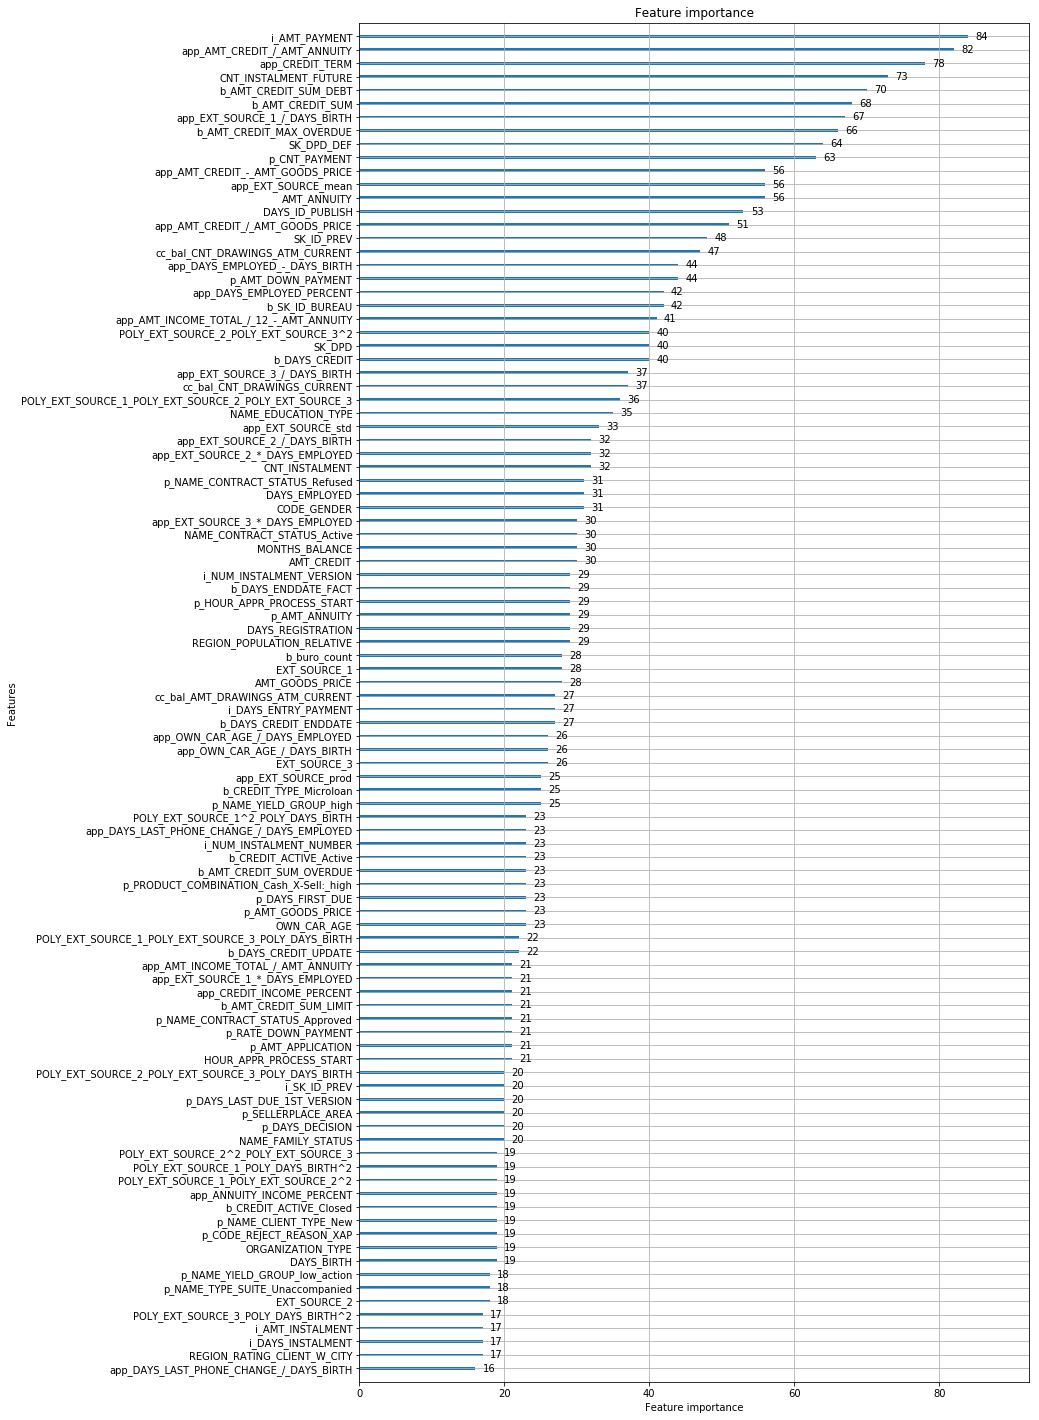

In [29]:
lgb.plot_importance(model, figsize=(12, 25), max_num_features=100);


### <a id="5.1">5.1 Predict</a>

In [30]:
preds = np.mean(list_preds, axis=0)

#preds = None

    
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("../output/5_lgbm_FeatureApp_DataClean_plus4.csv", index=False)
sub_lgb.head()

,SK_ID_CURR,TARGET
0,100001,0.038953
1,100005,0.094408
2,100013,0.016390
3,100028,0.029525
4,100038,0.190136


In [32]:
print('my base lgbm + probause, app domain, poly, data clean')
print(sc_auc_score, ',' ,max_score)

my base lgbm + probause, app domain, poly, data clean
0.7796809574809425 , 0.7807972037227437


In [33]:
print('result: 0.783')

result: 0.783
